In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from distcorr import distcorr
from scipy.stats import pearsonr

In [2]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [3]:
pd.set_option('display.max_rows', None)
df = pd.read_excel('dutch_census.xls')
df.shape

(6303, 97)

In [4]:
df.columns = df.iloc[1, :]

In [5]:
df = df.drop(df.index[1])
df = df.drop(columns=['Bedrijf en Beroep', 'Telling', 'Tabel', 'Pagina links', 'Pagina rechts', 'Provincie', 'Image nr Links', 'Image nr Rechts'])

In [6]:
df.replace(0, np.nan, inplace=True)
df.shape

(6302, 89)

In [7]:
df = df.dropna(how='all')
df.shape

(5784, 89)

In [8]:
df = df.dropna(axis=1, thresh=df.shape[0]*0.5)
df.shape

(5784, 3)

In [9]:
df = df.drop(df.index[0])

In [10]:
full_df = df.dropna()

In [11]:
array = full_df.to_numpy()

In [12]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(array)

In [13]:
average_value = np.mean(scaled_data.flatten())
average_value

0.0022928816748778186

In [14]:
full_data = scaled_data.copy()
missing_data = fill_nan(scaled_data, scaled_data.size*0.2)

In [15]:
bins = np.linspace(0, 500)
y_binned = np.digitize(full_data[:, 0], bins)

In [16]:
random.seed(1)
x_train, x_test, y_train, y_test = train_test_split(missing_data, full_data, stratify=y_binned, random_state=random.randint(1, 10))

In [17]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = -1
NUM_FEATURES = 3
BATCH_SIZE_TEST = -1

In [18]:
x_train = torch.from_numpy(x_train.astype(float))
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train.astype(float))
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test.astype(float))
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test.astype(float))
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([1909, 3])

In [41]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=3, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)

        self.dec1 = nn.Linear(in_features=16, out_features=8)
        self.dec2 = nn.Linear(in_features=8, out_features=3)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec1(x))
        x = self.dec2(x)
        return x

In [42]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [43]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [44]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=False)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                    print("Target: ", scaler.inverse_transform(full_data.reshape(-1,3)))
                    print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))
                else:
                    print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                    print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,3)))
                    print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        x_loss = running_loss / count
        train_loss.append(loss)



        print('Epoch {} of {}, Train Loss: {:.7f}, Overall: {:.7f}'
             .format(epoch+1, NUM_EPOCHS, x_loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        overall_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            overall_loss += loss.item()

            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                print("Target: ", scaler.inverse_transform(full_data.reshape(-1,3)))
                print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))
            else:
                print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,3)))
                print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,3)))
                print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,3).detach().numpy()))

        overall_loss = overall_loss / len(x_test)
        x_loss = running_loss / count
        test_loss.append(overall_loss)
        print('Test Loss: {:.7f}, Overall: {:.7f}'.format(x_loss, overall_loss))

        return test_loss

In [45]:
results = train(net)

 4654.67]]
Input (missing):  [[ 1. 29.  1.]]
Target (missing):  [[20. 29. 83.]]
Outputs (missing):  [[104.35  59.84 336.05]]
Input (missing):  [[151. 102.   1.]]
Target (missing):  [[151. 102. 955.]]
Outputs (missing):  [[ 239.07  167.99 1516.98]]
Input (missing):  [[ 1. 26.  1.]]
Target (missing):  [[ 16.  26. 124.]]
Outputs (missing):  [[136.22  89.29 702.53]]
Input (missing):  [[971. 304.   1.]]
Target (missing):  [[ 971.  304. 3360.]]
Outputs (missing):  [[ 881.14  668.36 7250.82]]
Input:  [[ 18703.  14225. 189325.]]
Target:  [[ 18703.  14225. 189325.]]
Outputs:  [[ 19483.83  15111.12 184887.57]]
Input:  [[ 1.  3. 34.]]
Target:  [[ 1.  3. 34.]]
Outputs:  [[102.97  56.63 534.73]]
Input (missing):  [[ 12.   1. 552.]]
Target (missing):  [[ 12.  89. 552.]]
Outputs (missing):  [[ 84.69  38.32 572.64]]
Input (missing):  [[846. 533.   1.]]
Target (missing):  [[ 846.  533. 4488.]]
Outputs (missing):  [[ 680.49  515.61 5435.36]]
Input:  [[ 449.   94. 1016.]]
Target:  [[ 449.   94. 1016.]]
O

In [46]:
test_result = test(net)

 1.  1. 67.]]
Target (missing):  [[13. 12. 67.]]
Outputs (missing):  [[ 40.66  28.13 555.93]]
Input (missing):  [[  1.   5. 336.]]
Target (missing):  [[ 20.   5. 336.]]
Outputs (missing):  [[ 47.48  33.04 648.3 ]]
Input (missing):  [[    1.     3. 24133.]]
Target (missing):  [[ 1599.     3. 24133.]]
Outputs (missing):  [[ 638.18  438.54 9183.79]]
Input:  [[ 28.  32. 276.]]
Target:  [[ 28.  32. 276.]]
Outputs:  [[ 66.98  49.35 784.71]]
Input (missing):  [[43.  9.  1.]]
Target (missing):  [[ 43.   9. 192.]]
Outputs (missing):  [[ 70.53  51.19 812.64]]
Input:  [[  9.   2. 149.]]
Target:  [[  9.   2. 149.]]
Outputs:  [[ 48.68  34.09 639.27]]
Input:  [[ 77.  26. 393.]]
Target:  [[ 77.  26. 393.]]
Outputs:  [[ 106.12   78.31 1169.44]]
Input:  [[ 8167.  2919. 21106.]]
Target:  [[ 8167.  2919. 21106.]]
Outputs:  [[ 6734.59  5200.2  61222.97]]
Input (missing):  [[11. 27.  1.]]
Target (missing):  [[ 11.  27. 103.]]
Outputs (missing):  [[ 47.34  34.73 574.41]]
Input (missing):  [[ 1.  9. 32.]]
Ta

In [35]:
torch.save(net, './model5')

In [23]:
net = torch.load('model5')
net

Autoencoder(
  (enc1): Linear(in_features=3, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=8, bias=True)
  (dec2): Linear(in_features=8, out_features=3, bias=True)
)

In [47]:
predicted_set = net(x_test.double())
predicted_set = scaler.inverse_transform(predicted_set.detach().numpy())

In [48]:
inverse_x = scaler.inverse_transform(x_test.detach().numpy())
inverse_y = scaler.inverse_transform(y_test.detach().numpy())

In [58]:
feature_1 = []
feature_2 = []

for missing_data, full_data, predicted in zip(x_test, inverse_y, predicted_set):
    if NAN in missing_data:
        for i in range(len(missing_data)):
            if missing_data[i] == NAN:
                if i == 1:
                    feature_1.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])
                if i == 2:
                    feature_2.append([full_data[0].item(), full_data[i].item(), predicted[i].item()])

In [59]:
feature_1 = np.asarray(feature_1)
feature_2 = np.asarray(feature_2)

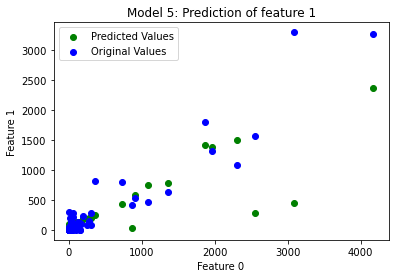

In [60]:
plt.scatter(feature_1[:, 0], feature_1[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_1[:, 0], feature_1[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.title('Model 5: Prediction of feature 1')
plt.show()

In [61]:
for i in range(15):
    max_index = np.where(feature_1 == np.amax(feature_1))

    feature_1 = np.delete(feature_1, max_index, 0)

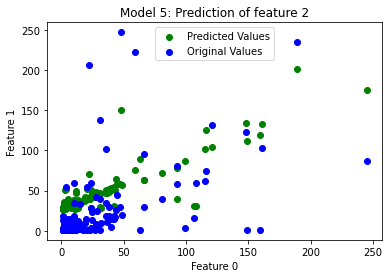

In [62]:
plt.scatter(feature_1[:, 0], feature_1[:, 2], color='green', label='Predicted Values')
plt.scatter(feature_1[:, 0], feature_1[:, 1], color='blue', label='Original Values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.title('Model 5: Prediction of feature 2')
plt.show()

In [64]:
features = [feature_1, feature_2]

for i in range(0, 2):
    print("Original Column: ", i+1, distcorr(features[i][:, 0], features[i][:, 1]))
    print("Predicted Column: ", i+1, distcorr(features[i][:, 0], features[i][:, 2]))

Original Column:  1 0.6235096881534249
Predicted Column:  1 0.860297555425728
Original Column:  2 0.9434631490897708
Predicted Column:  2 0.9496631072664194
